<a href="https://colab.research.google.com/github/FaisalWani123/DND/blob/main/LQG50M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 - Simplified Custom Object Detection

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of object detection: -from `loading and inspecting the dataset`; -to `implementing`, `training and evaluating a Convolutional Neural Network based architecture`. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- Please select at least ANY 3 objects of choice. Try to pick unique objects. You may pick more, but less than 3 is not acceptable and results in losing points;
- While we do not require a high performance model, we still expect you to have a model that performs better than "random guessing" (i.e. for 3 objects, mAP should be better than 33%);
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is October 25th Friday 11:59 PM** (strict, no late submission)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

**Name:**  
**Neptun ID:**
**Network:**
**Objects:**

## Task description

**Your task** is to train your own custom object detection model and compare its performance with an existing object detection model (i.e., YOLO). For that, you need to generate a synthetic dataset to train your own custom model and fine-tune an existing one. This is a simplified version of object detection, where each image must only contain a single object.

- There is no expectation of high performance, but **your metrics should show results better than random guessing, and your loss must decrease throughout the epochs**.

- We expect you to visualize the key metrics such as precision, recall, F1-score, mAP (mean average precision), IoU (Intersection over Union), and localization loss, in addition to monitoring the overall loss and its reduction across training. Use plots and visualizations (e.g., matplotlib, seaborn) to display metrics, losses, and predictions.

- You should implement techniques to avoid overfitting, such as Early Stopping, and save the best-performing model during training.

- Additionally, you can use **WandB (Weights and Biases)** or **TensorBoard** to track and visualize training progress, monitor the model's performance, and log metrics over time.

`Good luck!`

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

Faisal Wani

Neptun Code - LQG50M

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [ ]:
# ADD YOUR CODE HERE
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#mount google drive
from google.colab import drive
drive.mount('/content/drive')

#for loading images (objects and backgrounds)
import os
from PIL import Image
import matplotlib.pyplot as plt

#for dataset creation
import random
import numpy as np

Mounted at /content/drive


In [ ]:
# import shutil

# # Specify the path to the dataset directory
# dataset_dir = 'dataset'

# # Delete the entire dataset directory
# shutil.rmtree(dataset_dir)

# # Confirm it's been deleted
# if not os.path.exists(dataset_dir):
#     print(f"{dataset_dir} has been successfully deleted.")
# else:
#     print(f"Failed to delete {dataset_dir}.")


# 1. DATASET
**For this assignment you are free to pick any 3 objects of your choice.** Please avoid offensive, inappropriate or violent objects.

### 1.1. Load objects

**Please select 3 or more objects.** After selecting the objects, **remove the background, keeping only the object itself**. You can do this manually, online, or by using code (this step is not part of the assignment evaluation).

As an example, the following objects were chosen (with the background removed using the Segment Anything Model):

Loaded 3 images from /content/drive/My Drive/DND_Images/images


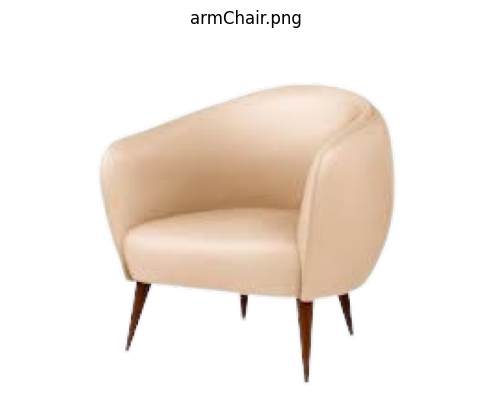

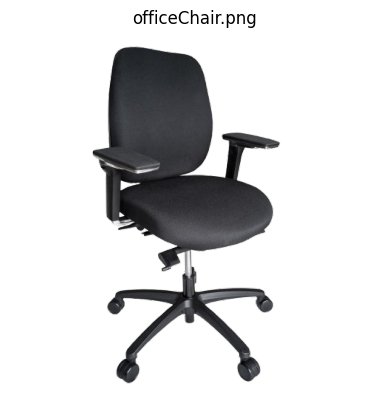

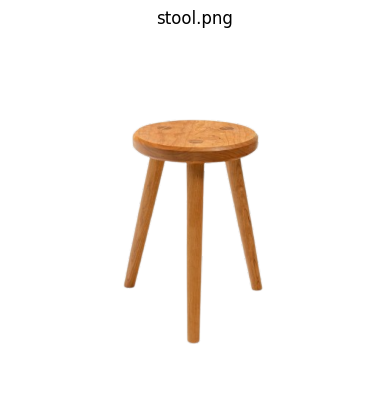

In [ ]:
#LOAD OBJECT IMAGES

# Function to load all images from a specified folder
def load_images(folder_path):
    images = []
    filenames = []
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image based on extension
        if filename.endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(folder_path, filename)
            # Open the image and convert to RGBA (or RGB if needed)
            img = Image.open(img_path).convert("RGBA")
            images.append(img)
            filenames.append(filename)  # Store the filenames to use for titles
    return images, filenames

# Load all of the object images
folder_path = '/content/drive/My Drive/DND_Images/images'  # Adjust this path if necessary
dnd_images, filenames = load_images(folder_path)

# Print how many images were loaded
print(f"Loaded {len(dnd_images)} images from {folder_path}")

# Display the images using matplotlib
for i, img in enumerate(dnd_images):
    plt.figure()
    plt.imshow(img)
    plt.title(filenames[i])  # Display the filename as the title of the image
    plt.axis('off')  # Hide axis for better visualization
    plt.show()


### 1.2. Load backgrounds

In order to train a custom object detection model, a dataset is needed. For this assignment, a synthetic dataset should be created by:

- **Inserting an object in a random position** on a background image.

**Therefore, collect a few background images from different locations** This can be done manually or via code.

It is recommended to use **icrawler** to automate the image collection process.


In [ ]:
!pip install icrawler

In [ ]:
!mkdir background

In case of any errors, try using a different crawler. You can use one of the following options:

```python
from icrawler.builtin import BaiduImageCrawler, BingImageCrawler, GoogleImageCrawler


In [ ]:
from icrawler.builtin import GoogleImageCrawler

google_crawler = GoogleImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir': 'background'}
)

for keyword in ['budapest', 'budapest parliament', 'buda castle', 'budapest st stephen basilica', 'budapest heroes square']:
    google_crawler.crawl(
        keyword=keyword, max_num=10, file_idx_offset='auto') #, min_size=(500, 500),)

#Some images may return an error, but icrawler tries to find other images regardless

ERROR:downloader:Response status code 202, file https://statemag.state.gov/wp-content/uploads/2022/08/0922pom-16-scaled.jpg
ERROR:downloader:Response status code 404, file https://www.alexanderroberts.com/getmedia/ae91d4f6-da53-4a5a-973b-d83a311a7549/shutterstock_272655443.jpg
ERROR:downloader:Response status code 404, file https://as1.ftcdn.net/v2/jpg


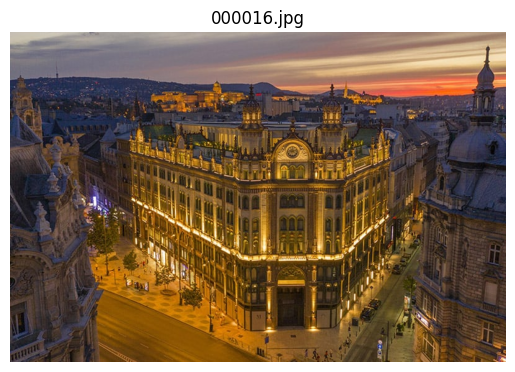

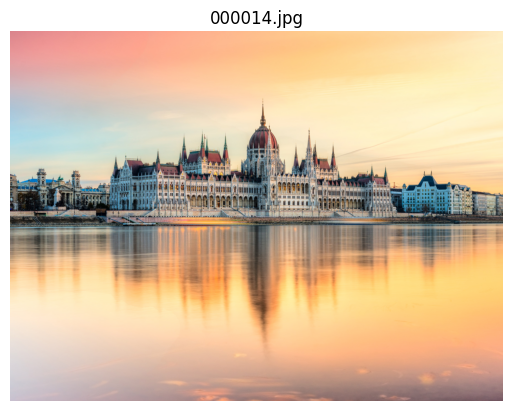

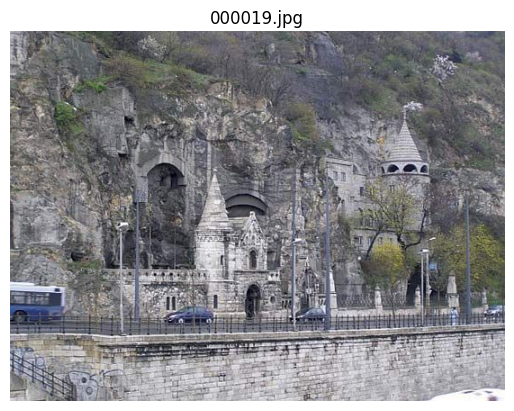

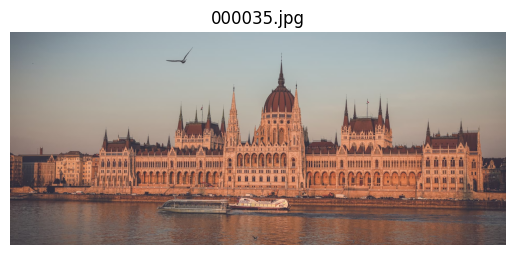

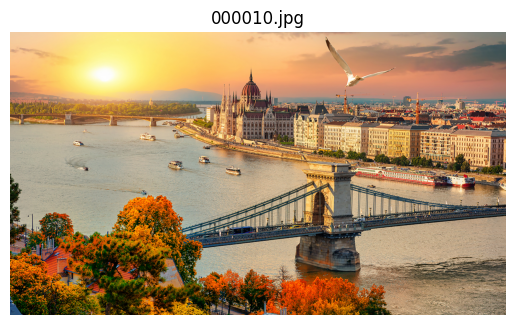

In [ ]:
def display_sample_images(directory):
    dnd_backgrounds = []  # Initialize the list for background images
    filenames = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path).convert("RGB")  # Convert image to RGB
            dnd_backgrounds.append(img)
            filenames.append(filename)

    # Display the first 5 images (or fewer if less than 5 available)
    num_images_to_display = min(5, len(dnd_backgrounds))

    for i in range(num_images_to_display):
        plt.figure()
        plt.imshow(dnd_backgrounds[i])
        plt.title(filenames[i])  # Show filename as the title
        plt.axis('off')  # Hide axis for better visualization
        plt.show()

    return dnd_backgrounds  # Return the loaded images

# Load and display sample images
directory = 'background'  # Ensure this is the correct directory for your background images
dnd_backgrounds = display_sample_images(directory)  # Store the loaded backgrounds

# Now, use dnd_backgrounds in your createDataset call
# createDataset('dataset', 'background', split='train', img_size=(640,640), num_images=5000, background_images=dnd_backgrounds, object_images=dnd_images)


### 1.3. Create dataset

### Dataset Creation

This is a crucial part of the assignment evaluation. From the selected objects and collected background images, follow these steps to generate your dataset:

1. **Randomly select background images** from your collection.
2. **Insert a single object** (from the three selected) into each background image at a **random location**.
3. **Record the object's coordinates** and create a corresponding bounding box. For example:
   - If an object with height `h` and width `w` is placed at position `(x, y)`, the bounding box should be in one of the following formats:
     - **[x, y, w, h]** or
     - **[x1, y1, x2, y2]**, where `x2 = x1 + w` and `y2 = y1 + h`.
4. If you plan to compare your custom model with a YOLO model, use the **YOLO bounding box format**:
   - `[(x + w/2)/image_width, (y + h/2)/image_height, w/image_width, h/image_height]`, where `image` refers to the background image dimensions.
5. **Save the generated dataset**, as it will be used for training your custom model and fine-tuning the existing object detection model.
6. **Wrap the dataset creation** in a **PyTorch Dataset class** for easier data handling and model training.
7. **Split the dataset** into training, validation, and test sets to evaluate your model effectively.


In [ ]:
def createDataset(root_dir, dataset_name, split, img_size, num_images):
    # Paths to save images and labels
    image_dir = os.path.join(root_dir, split, 'images')
    label_dir = os.path.join(root_dir, split, 'labels')

    # Create directories if they do not exist
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    # Load background images and objects
    backgrounds, _ = load_images('/content/drive/My Drive/DND_Images/backgrounds')
    objects, object_filenames = load_images('/content/drive/My Drive/DND_Images/images')  # Get object filenames too

    for i in range(num_images):
        # Randomly select a background and an object
        background = random.choice(backgrounds).copy()  # Copy to avoid modifying the original
        object_img_index = random.randint(0, len(objects) - 1)
        object_img = objects[object_img_index]

        # Extract class name from object filename (e.g., 'stool.png' -> 'stool')
        object_filename = object_filenames[object_img_index]
        class_name = os.path.splitext(object_filename)[0]

        # Get background and object sizes
        bg_w, bg_h = background.size
        obj_w, obj_h = object_img.size

        # Ensure object fits within background, resize if necessary
        if obj_w > bg_w or obj_h > bg_h:
            # Calculate resize ratio based on the larger dimension
            ratio = min(bg_w / obj_w, bg_h / obj_h)
            # Resize the object image
            object_img = object_img.resize((int(obj_w * ratio), int(obj_h * ratio)))
            # Update object dimensions after resizing
            obj_w, obj_h = object_img.size

        # Randomly select position for the object
        x = random.randint(0, bg_w - obj_w)
        y = random.randint(0, bg_h - obj_h)

        # Paste object onto background
        background.paste(object_img, (x, y), object_img)

        # Convert the image to RGB before saving
        background = background.convert("RGB")

        # Save the resulting image with the format "Sample X, Class: stool"
        img_filename = f"Sample {i:05d}, Class: {class_name}.jpg"
        background.save(os.path.join(image_dir, img_filename))

        # Calculate YOLO bounding box format
        yolo_x = (x + obj_w / 2) / bg_w
        yolo_y = (y + obj_h / 2) / bg_h
        yolo_w = obj_w / bg_w
        yolo_h = obj_h / bg_h

        # Save bounding box information to label file
        label_filename = f"Sample {i:05d}, Class: {class_name}.txt"
        with open(os.path.join(label_dir, label_filename), 'w') as f:
            # Assuming the object class is always 0 (you can change it)
            f.write(f"0 {yolo_x} {yolo_y} {yolo_w} {yolo_h}")

# Example usage to create train, val, and test splits should be 5k 2k 1k
createDataset('dataset', 'background', split='train', img_size=(640,640), num_images=1000)
createDataset('dataset', 'background', split='val', img_size=(640,640), num_images=500)
createDataset('dataset', 'background', split='test', img_size=(640,640), num_images=250)


In [ ]:
!pip install torchvision

In [ ]:
from torchvision import transforms
import os
from torch.utils.data import Dataset
import torch

class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, split='train', num_classes=3, transform=None):
        self.root_dir = root_dir
        self.split_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.split_dir, 'images')
        self.label_dir = os.path.join(self.split_dir, 'labels')
        self.image_filenames = sorted(os.listdir(self.image_dir))

        # Define the resize transform
        self.resize_transform = transforms.Resize((640, 640))  # Resize to 640x640

        # If a transform is provided, combine it with the resize transform
        if transform is not None:
            self.transform = transforms.Compose([
                transform,
                self.resize_transform  # Apply resize after other transforms
            ])
        else:
            # If no transform is provided, just use the resize transform
            self.transform = transforms.Compose([
                transforms.ToTensor(), # Convert image to tensor
                self.resize_transform
            ])

        self.num_classes = num_classes

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.image_filenames)

    def __getitem__(self, index):
      # Get the image filename and label filename
      image_filename = self.image_filenames[index]
      label_filename = os.path.splitext(image_filename)[0] + '.txt'

      # Load the image
      image_path = os.path.join(self.image_dir, image_filename)
      image = Image.open(image_path).convert('RGB')  # Ensure RGB format

      # Apply transforms if any
      if self.transform:
          image = self.transform(image)

      # Load and process labels and bounding boxes (if available)
      label_path = os.path.join(self.label_dir, label_filename)

      # Load the image
      img = Image.open(image_path).convert("RGB")  # Convert to RGB to ensure consistency
      if self.transform:
          img = self.transform(img)

      # Load the label (bounding box) from the txt file
      with open(label_path, 'r') as f:
          label = f.readline().strip().split()
          category = int(label[0])  # Assuming the first value is the class index
          bbox = [float(x) for x in label[1:]]  # The rest are the bounding box coordinates

      # Return the image, category, bounding box, and filename
      return img, torch.tensor(category), torch.tensor(bbox), self.image_filenames[index]



In [ ]:
root_dir = 'dataset'
transform = transforms.Compose([
    transforms.ToTensor(),
])

from torch.utils.data import DataLoader

# When initializing DataLoader, set num_workers to 2 by putting batch size to 32 instead of 16


train_dataset = ObjectDetectionDataset(root_dir, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = ObjectDetectionDataset(root_dir, split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


test_dataset = ObjectDetectionDataset(root_dir, split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


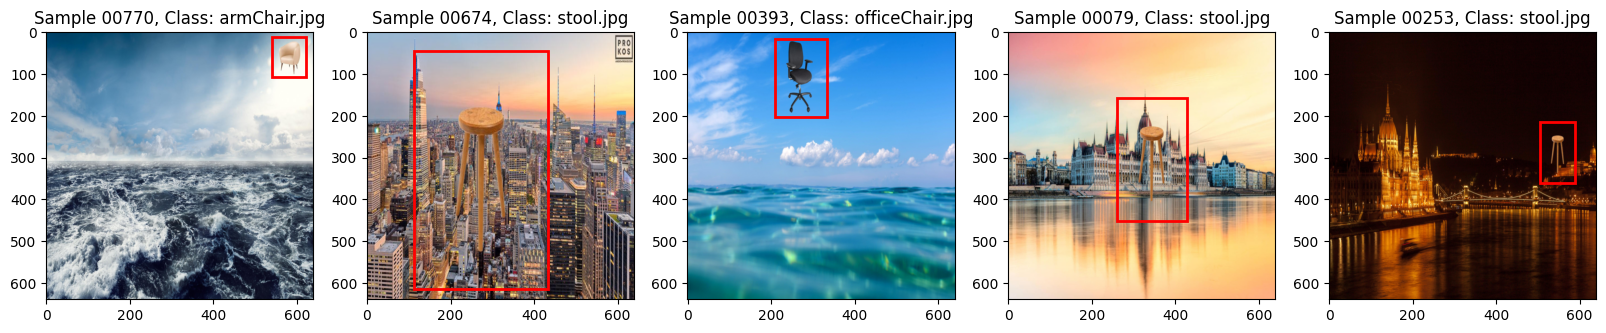

In [ ]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import random

# Show some visualizations of the created dataset
def visualize_dataset(dataset, num_samples=5):
    # Set up matplotlib figure with num_samples subplots
    fig, ax = plt.subplots(1, num_samples, figsize=(20, 5))

    # Loop over the number of samples to visualize
    for i in range(num_samples):
        # Get a random sample from the dataset
        img, category, bbox, filename = dataset[random.randint(0, len(dataset) - 1)]

        # Convert the image to NumPy and transpose to (H, W, C) format
        img = img.permute(1, 2, 0).numpy()

        # Get image dimensions
        img_h, img_w, _ = img.shape

        # Extract YOLO format bounding box and convert to pixel coordinates
        x_center, y_center, box_w, box_h = bbox
        x1 = (x_center - box_w / 2) * img_w
        y1 = (y_center - box_h / 2) * img_h
        box_w = box_w * img_w
        box_h = box_h * img_h

        # Display the image
        ax[i].imshow(img)

        # Create a Rectangle patch for the bounding box
        rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)

        # Add the image name (filename) as the title
        ax[i].set_title(f"{filename}")
        ax[i].axis('on')  # Hide the axis for better visualization

    # Show the plot
    plt.show()

# Example: Call the function to visualize the validation dataset
visualize_dataset(train_dataset)


### 2. MODELS

In this assignment, you are tasked with building your own custom object detection model and comparing its performance against an existing object detection model.


### 2.1. Custom Object Detection model

### Create a Convolutional Neural Network (CNN) Architecture

Design a CNN-based architecture that includes a **backbone for feature extraction** and two output branches:

- One for **class probabilities** (with output size equal to the number of object classes, e.g., 3).
- Another for **bounding box regression** (with size 4 for the box coordinates: x, y, w, h, or in your chosen format).

This is the core evaluation of the assignment. Experiment with different layers, hyperparameters, and regularization techniques to optimize the model's performance.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomModel, self).__init__()

        # Define custom backbone
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Input channels = 3 (RGB)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample to 16x16

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample to 8x8

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Downsample to 4x4
        )

        # Calculate the feature size dynamically
        self.feature_size = self._get_feature_size()

        # Detection layers
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_size, 128),  # Adjust input size here
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Output layer for class probabilities
        )

        self.bbox_regressor = nn.Sequential(
            nn.Linear(self.feature_size, 128),  # Adjust input size here
            nn.ReLU(),
            nn.Linear(128, 4)  # Output layer for bounding box regression
        )

    def _get_feature_size(self):
        # Create a dummy tensor to pass through the backbone to get output size
        dummy_input = torch.randn(1, 3, 640, 640)
        with torch.no_grad():
            output = self.backbone(dummy_input)
        return output.view(-1).shape[0]  # Flatten and get size

    def forward(self, x):
        # Pass input through the backbone
        x = self.backbone(x)
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layers

        # Get class probabilities
        class_probs = self.classifier(x)

        # Get bounding box regression
        bbox_regression = self.bbox_regressor(x)

        return class_probs, bbox_regression

# Dummy input to test the model
dummy_image = torch.randn(1, 3, 640, 640).to(device)
num_classes = 3

model = CustomModel(num_classes).to(device)
cls_output, bbox_output = model(dummy_image)

print("Class Output Shape:", cls_output.shape)
print("Bounding Box Output Shape:", bbox_output.shape)


Class Output Shape: torch.Size([1, 3])
Bounding Box Output Shape: torch.Size([1, 4])


In [ ]:
dummy_image = torch.randn(1, 3, 640, 640).to(device)
num_classes = 3

model = CustomModel(num_classes).to(device)
cls_output, bbox_output = model(dummy_image)

print("Class Output Shape:", cls_output.shape)
print("Bounding Box Output Shape:", bbox_output.shape)

Class Output Shape: torch.Size([1, 3])
Bounding Box Output Shape: torch.Size([1, 4])


### 2.2. Train Your Model

Carefully choose key components like the **optimizer**, **loss function**, **number of epochs**, and **regularization techniques**. Ensure you're optimizing both **classification loss** and **bounding box regression loss**.

Monitor for signs of **overfitting** or **underfitting** by tracking how the loss evolves across epochs. The loss should consistently decrease as training progresses. Save and log these losses for visualization and further analysis.


**Example Plot**:

<a href="https://ibb.co/bzmMxJY"><img src="https://i.ibb.co/t8KTSXn/download.png" alt="download" border="0"></a>

In [ ]:
# import torch.optim as optim
# import matplotlib.pyplot as plt

# # Define optimizer and loss functions
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as necessary
# class_loss_fn = nn.CrossEntropyLoss()  # For class probabilities
# bbox_loss_fn = nn.MSELoss()  # For bounding box regression

# def train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=10):
#     train_losses = []
#     val_losses = []

#     for epoch in range(num_epochs):
#         model.train()  # Set model to training mode
#         total_train_loss = 0

#         for images, labels, bboxes, filenames in train_loader:
#             images = images.to(device)
#             labels = labels.to(device)
#             bboxes = bboxes.to(device)

#             optimizer.zero_grad()  # Clear gradients

#             # Forward pass
#             class_outputs, bbox_outputs = model(images)

#             # Debug output shapes
#             print(f'Class Outputs Shape: {class_outputs.shape if class_outputs is not None else "None"}')
#             print(f'Bounding Box Outputs Shape: {bbox_outputs.shape if bbox_outputs is not None else "None"}')

#             # Check output shapes
#             if class_outputs is None or bbox_outputs is None:
#                 print("Model output is None")
#                 continue  # Skip this iteration if outputs are None

#             # Calculate losses
#             class_loss = class_loss_fn(class_outputs, labels)
#             bbox_loss = bbox_loss_fn(bbox_outputs, bboxes)
#             total_loss = class_loss + bbox_loss  # Combine losses

#             # Backward pass and optimization
#             total_loss.backward()
#             optimizer.step()

#             total_train_loss += total_loss.item()

#         avg_train_loss = total_train_loss / len(train_loader)
#         train_losses.append(avg_train_loss)

#         # Validation phase
#         model.eval()  # Set model to evaluation mode
#         total_val_loss = 0

#         with torch.no_grad():
#             for images, labels, bboxes, filenames in val_loader:
#                 images = images.to(device)
#                 labels = labels.to(device)
#                 bboxes = bboxes.to(device)

#                 # Forward pass
#                 class_outputs, bbox_outputs = model(images)

#                 # Debug output shapes
#                 print(f'Validation Class Outputs Shape: {class_outputs.shape if class_outputs is not None else "None"}')
#                 print(f'Validation Bounding Box Outputs Shape: {bbox_outputs.shape if bbox_outputs is not None else "None"}')

#                 # Check output shapes
#                 if class_outputs is None or bbox_outputs is None:
#                     print("Validation model output is None")
#                     continue  # Skip this iteration if outputs are None

#                 # Calculate validation losses
#                 class_loss = class_loss_fn(class_outputs, labels)
#                 bbox_loss = bbox_loss_fn(bbox_outputs, bboxes)
#                 total_loss = class_loss + bbox_loss
#                 total_val_loss += total_loss.item()

#         avg_val_loss = total_val_loss / len(val_loader)
#         val_losses.append(avg_val_loss)

#         print(f'Epoch [{epoch + 1}/{num_epochs}], '
#               f'Train Loss: {avg_train_loss:.4f}, '
#               f'Validation Loss: {avg_val_loss:.4f}')

#     return train_losses, val_losses


# def plot_losses(train_losses, val_losses):
#     plt.figure(figsize=(10, 5))
#     plt.plot(train_losses, label='Training Loss', color='blue')
#     plt.plot(val_losses, label='Validation Loss', color='orange')
#     plt.title('Training and Validation Losses')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid()
#     plt.show()

# # Train the model
# try:
#     train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=15)
#     plot_losses(train_losses, val_losses)
# except Exception as e:
#     print(f"Error during training: {e}")


we are using the one below

training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
Epoch [1/3], Train Loss: 0.0230, Val Loss: 0.0158, Train Class Loss: 0.0001, Train BBox Loss: 0.0230, Val Class Loss: 0.0000, Val BBox Loss: 0.0158
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
training
Epoch [2/3], Train Loss: 0.0147, Val Loss: 0.0132, Train Class Loss: 0.0000, Train BBox Loss: 0.0147, Val Class Loss: 0.0000, Val BBox Loss: 0.0132
training
training
training
training
training
training
training
training
training
training
training
training
training
training
tr

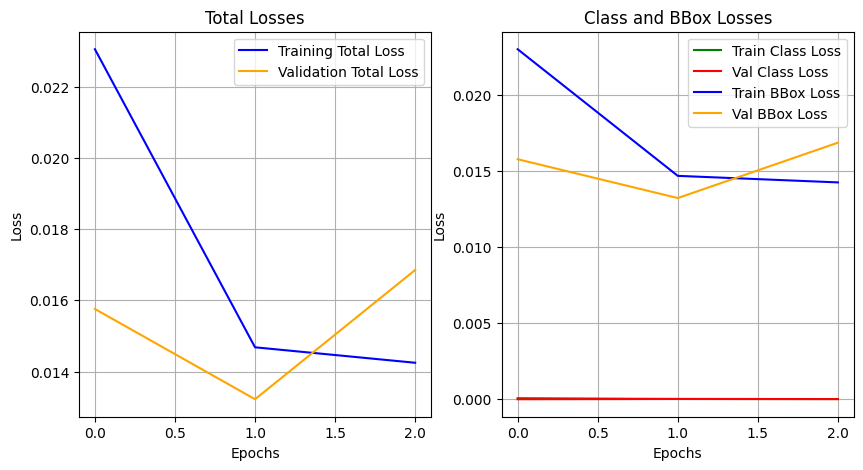

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn

# Define optimizer and loss functions
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay for regularization
class_loss_fn = nn.CrossEntropyLoss()  # For class probabilities
bbox_loss_fn = nn.SmoothL1Loss()  # Consider SmoothL1Loss for bounding box regression

def train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=10):
    train_losses = []
    val_losses = []
    train_class_losses = []
    train_bbox_losses = []
    val_class_losses = []
    val_bbox_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0
        total_train_class_loss = 0
        total_train_bbox_loss = 0

        for images, labels, bboxes, filenames in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)

            optimizer.zero_grad()  # Clear gradients

            # Forward pass
            class_outputs, bbox_outputs = model(images)

            # Calculate losses
            class_loss = class_loss_fn(class_outputs, labels)
            bbox_loss = bbox_loss_fn(bbox_outputs, bboxes)
            total_loss = class_loss + bbox_loss  # Combine losses

            # Backward pass and optimization
            total_loss.backward()
            print('training')
            optimizer.step()

            # Accumulate losses
            total_train_loss += total_loss.item()
            total_train_class_loss += class_loss.item()
            total_train_bbox_loss += bbox_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_class_loss = total_train_class_loss / len(train_loader)
        avg_train_bbox_loss = total_train_bbox_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_class_losses.append(avg_train_class_loss)
        train_bbox_losses.append(avg_train_bbox_loss)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0
        total_val_class_loss = 0
        total_val_bbox_loss = 0

        with torch.no_grad():
            for images, labels, bboxes, filenames in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                bboxes = bboxes.to(device)

                # Forward pass
                class_outputs, bbox_outputs = model(images)

                # Calculate validation losses
                class_loss = class_loss_fn(class_outputs, labels)
                bbox_loss = bbox_loss_fn(bbox_outputs, bboxes)
                total_loss = class_loss + bbox_loss

                total_val_loss += total_loss.item()
                total_val_class_loss += class_loss.item()
                total_val_bbox_loss += bbox_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_class_loss = total_val_class_loss / len(val_loader)
        avg_val_bbox_loss = total_val_bbox_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_class_losses.append(avg_val_class_loss)
        val_bbox_losses.append(avg_val_bbox_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, '
              f'Train Class Loss: {avg_train_class_loss:.4f}, '
              f'Train BBox Loss: {avg_train_bbox_loss:.4f}, '
              f'Val Class Loss: {avg_val_class_loss:.4f}, '
              f'Val BBox Loss: {avg_val_bbox_loss:.4f}')

    return train_losses, val_losses, train_class_losses, val_class_losses, train_bbox_losses, val_bbox_losses

def plot_losses(train_losses, val_losses, train_class_losses, val_class_losses, train_bbox_losses, val_bbox_losses):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Total Loss', color='blue')
    plt.plot(val_losses, label='Validation Total Loss', color='orange')
    plt.title('Total Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_class_losses, label='Train Class Loss', color='green')
    plt.plot(val_class_losses, label='Val Class Loss', color='red')
    plt.plot(train_bbox_losses, label='Train BBox Loss', color='blue')
    plt.plot(val_bbox_losses, label='Val BBox Loss', color='orange')
    plt.title('Class and BBox Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Train the model and plot losses
try:
    train_losses, val_losses, train_class_losses, val_class_losses, train_bbox_losses, val_bbox_losses = train_model(
        model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=3
    )
    plot_losses(train_losses, val_losses, train_class_losses, val_class_losses, train_bbox_losses, val_bbox_losses)
except Exception as e:
    print(f"Error during training: {e}")


In [ ]:
#  # Check the output of train_loader
# for data in train_loader:
#     images, labels, bboxes_info, filenames = data  # Adjusted to unpack the filenames
#     print("Images shape:", images.shape)
#     print("Labels shape:", labels.shape)
#     print("Bounding boxes shape:", bboxes_info.shape)
#     print("Filenames:", filenames)  # Print filenames if needed
#     break  # Just print the first batch and exit


### 2.3. Evaulate and do inference with the trained custom model

Choose **at least 3 metrics** to evaluate your object detection model. These could include:

- **Precision**: The proportion of correctly predicted positive instances (objects detected) out of all instances classified as positive.
- **Recall**: The proportion of correctly predicted positive instances out of all actual positive instances (objects present in the image).
- **F1-Score**: The harmonic mean of Precision and Recall, balancing false positives and false negatives.
- **IoU (Intersection over Union)**: Measures the overlap between the predicted bounding box and the ground truth bounding box.
- **mAP (mean Average Precision)**: This is one of the most common evaluation metrics for object detection. It averages precision at different recall thresholds across all object classes.
  
Additionally, you can assess:
- **Inference speed**: Time taken by the model to process a single image.
- **Number of parameters**: The total number of trainable parameters in the model.
- **Model size**: The disk size of the trained model.

### Show Performance Metric Visualizations

- Visualize the chosen metrics (e.g., **Precision, Recall, F1-Score, IoU, mAP**) over different epochs to demonstrate the improvement in the model’s performance.
- Plot losses (both classification loss and localization loss) to show how they decrease throughout training.

### Show Some Predictions of Your Trained Model

- Display sample images with **predicted bounding boxes** and compare them to the ground truth.
- Highlight the values of **Precision, Recall, IoU**, or other relevant metrics for each displayed prediction, giving a clear view of the model's performance.
  
You can also use **WandB (Weights and Biases)** or **TensorBoard** for more detailed logging and tracking of these metrics and visualizations.


In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score
import numpy as np

def calculate_iou(box1, box2):
    """Calculate the IoU (Intersection over Union) between two bounding boxes.
    box1, box2: (x_min, y_min, x_max, y_max)
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    union = box1_area + box2_area - intersection

    return intersection / union if union != 0 else 0

def evaluate_test_set(model, test_loader, device, iou_threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []
    ious = []

    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    with torch.no_grad():
        for images, labels, bboxes, filenames in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)

            # Get model predictions
            class_outputs, bbox_outputs = model(images)

            # Convert outputs to numpy for further evaluation
            predicted_labels = torch.argmax(class_outputs, dim=1).cpu().numpy()
            predicted_bboxes = bbox_outputs.cpu().numpy()
            true_labels = labels.cpu().numpy()
            true_bboxes = bboxes.cpu().numpy()

            all_preds.extend(predicted_labels)
            all_labels.extend(true_labels)

            # Calculate IoU for each predicted box with ground truth
            for i in range(len(true_bboxes)):
                pred_box = predicted_bboxes[i]
                true_box = true_bboxes[i]

                iou = calculate_iou(pred_box, true_box)
                ious.append(iou)

                if iou >= iou_threshold and predicted_labels[i] == true_labels[i]:
                    total_true_positives += 1
                elif predicted_labels[i] == true_labels[i]:
                    total_false_negatives += 1
                else:
                    total_false_positives += 1

    # Calculate precision and recall using sklearn
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Calculate mean IoU
    mean_iou = np.mean(ious)

    # Calculate mAP (you would normally compute this per class and average, but simplified here)
    # mAP is often computed as the area under the precision-recall curve (simplified here)
    mAP = precision * recall

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'mAP: {mAP:.4f}')
    print(f'Mean IoU: {mean_iou:.4f}')

    return precision, recall, mAP, mean_iou

# Evaluate the test set
precision, recall, mAP, mean_iou = evaluate_test_set(model, test_loader, device)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Precision: 1.0000
Recall: 1.0000
mAP: 1.0000
Mean IoU: 0.5262


In [ ]:
precision, recall, mAP, mean_iou = evaluate_test_set(model, val_loader, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TypeError: '>=' not supported between instances of 'NoneType' and 'float'

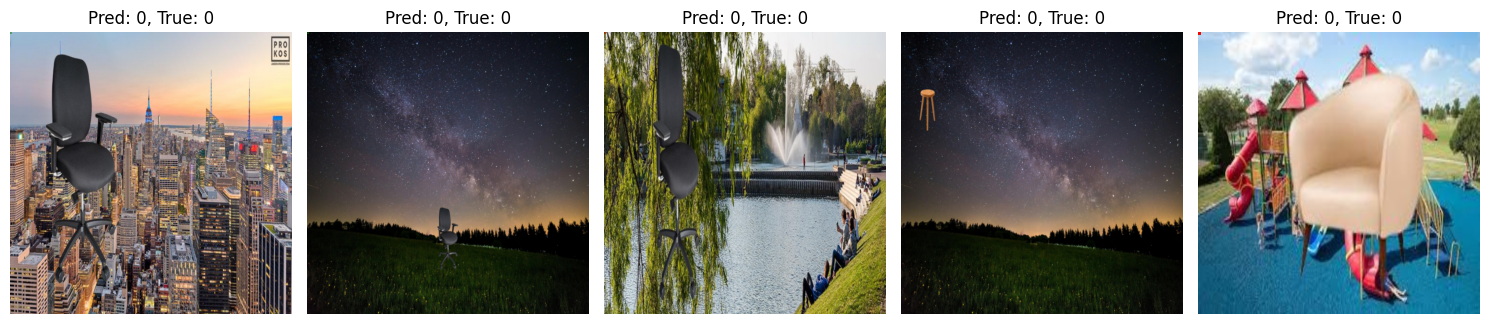

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to visualize predictions
def visualize_predictions(model, test_dataset, num_samples=5, device='cuda'):
    # Check if CUDA is available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))  # Create a plot with num_samples images

    for i in range(num_samples):
        # Get a sample from the test dataset
        image, label, bbox, filename = test_dataset[i]

        # Move the image to the model's device (e.g., GPU or CPU)
        image = image.unsqueeze(0).to(device)

        # Generate predictions
        with torch.no_grad():
            class_output, bbox_output = model(image)

        # Convert model outputs to numpy arrays for easier handling
        predicted_label = torch.argmax(class_output, dim=1).cpu().item()  # Get the predicted class label
        predicted_bbox = bbox_output.cpu().numpy()[0]  # Get the predicted bounding box

        # Process the image
        image = image.squeeze(0).cpu().permute(1, 2, 0).numpy()  # Convert tensor to numpy image (H, W, C)

        # Ensure the image values are in the valid range [0, 1] for floats
        image = np.clip(image, 0, 1)

        # Plot the image
        axs[i].imshow(image)

        # Plot the ground truth bounding box
        true_box = bbox.numpy()
        rect = plt.Rectangle((true_box[0], true_box[1]), true_box[2] - true_box[0], true_box[3] - true_box[1],
                             linewidth=2, edgecolor='green', facecolor='none', label='Ground Truth')
        axs[i].add_patch(rect)

        # Plot the predicted bounding box
        rect_pred = plt.Rectangle((predicted_bbox[0], predicted_bbox[1]),
                                  predicted_bbox[2] - predicted_bbox[0],
                                  predicted_bbox[3] - predicted_bbox[1],
                                  linewidth=2, edgecolor='red', facecolor='none', label='Prediction')
        axs[i].add_patch(rect_pred)

        # Add title and class information
        axs[i].set_title(f"Pred: {predicted_label}, True: {label}")
        axs[i].axis('off')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function to visualize predictions
visualize_predictions(model, test_dataset)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score

def calculate_iou(box1, box2):
    """Calculate the IoU (Intersection over Union) between two bounding boxes.
    box1, box2: (x_min, y_min, x_max, y_max)
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    union = box1_area + box2_area - intersection

    return intersection / union if union != 0 else 0

def evaluate_validation_set(model, val_loader, device, iou_threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    ious = []

    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    with torch.no_grad():
        for images, labels, bboxes, filenames in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)

            # Get model predictions
            outputs = model(images)

            # Debugging model output
            print(f"Model Outputs: {outputs}")

            if isinstance(outputs, tuple):
                class_outputs, bbox_outputs = outputs[:2]  # Modify if needed for additional outputs
            else:
                class_outputs = outputs
                bbox_outputs = None  # Adjust if your model outputs bounding boxes separately

            # Check if class_outputs are valid
            print(f"Class Outputs: {class_outputs}")

            # Convert outputs to numpy for further evaluation
            predicted_labels = torch.argmax(class_outputs, dim=1).cpu().numpy()
            true_labels = labels.cpu().numpy()

            # Debugging output to check labels
            print(f"Predicted Labels: {predicted_labels}")
            print(f"True Labels: {true_labels}")

            # Ensure that labels are in the same format and have the correct dimensions
            predicted_labels = predicted_labels.reshape(-1)  # Flatten predictions
            true_labels = true_labels.reshape(-1)  # Flatten true labels

            # Ensure both predicted_labels and true_labels have the same length for this batch
            min_len = min(len(predicted_labels), len(true_labels))
            predicted_labels = predicted_labels[:min_len]
            true_labels = true_labels[:min_len]

            all_preds.extend(predicted_labels)
            all_labels.extend(true_labels)

            # Handle IoU calculation if bounding boxes are available
            if bbox_outputs is not None:
                predicted_bboxes = bbox_outputs.cpu().numpy()
                true_bboxes = bboxes.cpu().numpy()

                # Debugging output
                print(f"Predicted BBoxes: {predicted_bboxes}")
                print(f"True BBoxes: {true_bboxes}")

                # Ensure bboxes have same length as labels
                predicted_bboxes = predicted_bboxes[:min_len]
                true_bboxes = true_bboxes[:min_len]

                for i in range(min_len):  # iterate up to the minimum length
                    pred_box = predicted_bboxes[i]
                    true_box = true_bboxes[i]

                    iou = calculate_iou(pred_box, true_box)
                    ious.append(iou)

                    if iou >= iou_threshold and predicted_labels[i] == true_labels[i]:
                        total_true_positives += 1
                    elif predicted_labels[i] == true_labels[i]:
                        total_false_negatives += 1
                    else:
                        total_false_positives += 1

    # Calculate precision and recall using sklearn, ensuring compatibility for multiclass
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

    # Calculate mean IoU
    mean_iou = np.mean(ious) if ious else 0.0

    # Simplified mAP calculation
    mAP = precision * recall
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'mAP: {mAP:.4f}')
    print(f'Mean IoU: {mean_iou:.4f}')
    print(f'Total True Positives: {total_true_positives}')
    print(f'Total False Negatives: {total_false_negatives}')
    print(f'Total False Positives: {total_false_positives}')

    return precision, recall, mAP, mean_iou


In [ ]:
val_precision, val_recall, val_mAP, val_mean_iou = evaluate_validation_set(model, val_loader, device)


Model Outputs: (tensor([[ 7.2237, -5.5385, -5.4939],
        [ 6.9940, -5.3789, -5.3366],
        [ 7.0560, -5.3898, -5.3461],
        [ 7.2872, -5.5879, -5.5421],
        [ 7.0530, -5.3874, -5.3438],
        [ 7.6783, -5.8625, -5.8069],
        [ 7.6696, -5.8556, -5.8002],
        [ 7.5008, -5.7617, -5.7133],
        [ 7.5041, -5.7642, -5.7157],
        [ 7.4907, -5.7538, -5.7056],
        [ 7.5609, -5.8077, -5.7567],
        [ 7.4909, -5.7540, -5.7058],
        [ 7.1535, -5.4715, -5.4266],
        [ 7.3220, -5.6012, -5.5532],
        [ 7.0016, -5.3848, -5.3424],
        [ 7.0008, -5.3840, -5.3416],
        [ 6.3354, -4.8316, -4.8022],
        [ 6.3384, -4.8339, -4.8045],
        [ 7.0464, -5.3824, -5.3389],
        [ 6.3247, -4.8224, -4.7931],
        [ 7.4261, -5.7015, -5.6529],
        [ 7.6728, -5.8583, -5.8028],
        [ 7.4316, -5.7046, -5.6559],
        [ 7.2309, -5.5434, -5.4986],
        [ 6.3596, -4.8499, -4.8199],
        [ 7.4389, -5.6934, -5.6424],
        [ 7.4584, -5.7

Validation Dataset

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# # Function to visualize predictions
# def visualize_predictions(model, test_dataset, num_samples=5, device='cuda'):
#     # Check if CUDA is available, otherwise use CPU
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)
#     model.eval()  # Set the model to evaluation mode

#     fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))  # Create a plot with num_samples images

#     for i in range(num_samples):
#         # Get a sample from the test dataset
#         image, label, bbox, filename = test_dataset[i]

#         # Move the image to the model's device (e.g., GPU or CPU)
#         image = image.unsqueeze(0).to(device)

#         # Generate predictions
#         with torch.no_grad():
#             class_output, bbox_output = model(image)

#         # Convert model outputs to numpy arrays for easier handling
#         predicted_label = torch.argmax(class_output, dim=1).cpu().item()  # Get the predicted class label
#         predicted_bbox = bbox_output.cpu().numpy()[0]  # Get the predicted bounding box

#         # Process the image
#         image = image.squeeze(0).cpu().permute(1, 2, 0).numpy()  # Convert tensor to numpy image (H, W, C)

#         # Ensure the image values are in the valid range [0, 1] for floats
#         image = np.clip(image, 0, 1)

#         # Plot the image
#         axs[i].imshow(image)

#         # Plot the ground truth bounding box
#         true_box = bbox.numpy()
#         rect = plt.Rectangle((true_box[0], true_box[1]), true_box[2] - true_box[0], true_box[3] - true_box[1],
#                              linewidth=2, edgecolor='green', facecolor='none', label='Ground Truth')
#         axs[i].add_patch(rect)

#         # Plot the predicted bounding box
#         rect_pred = plt.Rectangle((predicted_bbox[0], predicted_bbox[1]),
#                                   predicted_bbox[2] - predicted_bbox[0],
#                                   predicted_bbox[3] - predicted_bbox[1],
#                                   linewidth=2, edgecolor='red', facecolor='none', label='Prediction')
#         axs[i].add_patch(rect_pred)

#         # Add title and class information
#         axs[i].set_title(f"Pred: {predicted_label}, True: {label}")
#         axs[i].axis('off')

#     # Display the plot
#     plt.tight_layout()
#     plt.show()

# # Call the function to visualize predictions
# visualize_predictions(model, val_dataset)


### 2.4. Load an Existing Object Detection Model

We recommend using the latest **YOLO** version, but you are free to choose any other **PyTorch-based** object detection model.


In [ ]:
# ADD YOUR CODE HERE

In [ ]:
!pip install yolov5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.1/877.1 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=315e9

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
!pip install -r yolov5/requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17022, done.
remote: Total 17022 (delta 0), reused 0 (delta 0), pack-reused 17022 (from 1)
Receiving objects: 100% (17022/17022), 15.62 MiB | 22.50 MiB/s, done.
Resolving deltas: 100% (11694/11694), done.


In [ ]:
import torch

# Load a pre-trained YOLOv5 model (YOLOv5s is the small model; you can choose other variants like YOLOv5m, YOLOv5l, YOLOv5x)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Print model architecture
print(model)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-10-24 Python-3.10.12 torch-2.5.0+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 76.9MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [ ]:
def evaluate_yolo(model, test_loader, device):
    model.eval()
    all_detections = []

    for batch in test_loader:
        images, labels, bboxes, _ = batch
        images = images.to(device)

        # Perform inference (model output is raw tensor for batch input)
        results = model(images)

        # Process results tensor manually
        for i, image_result in enumerate(results):
            # Assuming results are in (batch_size, num_detections, 6) format, where 6 = [x1, y1, x2, y2, confidence, class]
            detection_per_image = image_result.cpu().detach().numpy()  # Convert to numpy for easy handling

            # Append results for each image in the batch
            all_detections.append(detection_per_image)

    return all_detections

# Example usage
detections = evaluate_yolo(model, test_loader, device)

# Example to print detections for the first image
print(detections[0])  # Detected boxes for the first image in the test_loader batch


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:865: FutureWarning: `torch.cuda.am

[[     2.9212      3.7894      6.5004 ...   0.0008216  0.00034149   0.0014539]
 [      9.525      3.5398      18.343 ...  0.00099356  0.00043826   0.0014982]
 [     18.505      3.4502      24.004 ...   0.0010269  0.00052891   0.0023367]
 ...
 [     564.87      614.33      142.76 ...   0.0038272   0.0010907   0.0013323]
 [     587.67      615.28      129.91 ...   0.0021546  0.00099828   0.0010727]
 [     619.59      624.11      127.04 ...   0.0017217  0.00096124  0.00093417]]


### 2.5. Fine-tune the existing object detection model
If you choose to use **YOLO**, training the model can be done easily by providing a `data.yaml` file (which follows a specific format, check the official GitHub repository for details) and running the training script.

For example, you can run YOLO from the command line with:

```bash
!yolo task=detect mode=train data=datasets/data.yaml model=yolov8n.yaml epochs=200 imgsz=640
```

Make sure to show the losses and metrics visualizations. By default, YOLO should **verbose** those.

In [ ]:
# ADD YOUR CODE HERE

data.yaml file below, put in dataset folder

train: /content/dataset/train/images
val: /content/dataset/val/images

nc: 3
names: ['armChair', 'officeChair', 'stool']


In [ ]:
#should be 200 epochs
!yolo task=detect mode=train data=dataset/data.yaml model=yolov8n.yaml epochs=3 imgsz=640

Ultralytics 8.3.21 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=dataset/data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

Running Yolo on mode validation below

In [ ]:
!yolo task=detect mode=val data=dataset/data.yaml model=runs/detect/train4/weights/best.pt


Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 797, in entrypoint
    model = YOLO(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 145, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 285, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 910, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 837, in torch_safe_load
    ckpt = torch.load(fi

### 2.6 Evaluate the existing object detection model
**Compare the performance** of your custom model and the YOLO model, ensuring both are evaluated on the **same subset of images** using the **same metrics** chosen in **Step 2.3** (e.g., Precision, Recall, F1-Score, IoU, mAP).


# 3. COMPARISON
**Compare the performance** of your custom model and the YOLO model, ensuring both are evaluated on the **same subset of images** for a fair comparison. Key metrics to include:

- **Precision**
- **Recall**
- **F1-Score**
- **IoU (Intersection over Union)**
- **mAP (mean Average Precision)**

### Visualize Predictions

- Show predictions from both models on the same images.
- Include bounding boxes, class labels, and relevant metrics like IoU or Precision.

### Explain Differences

- Discuss why one model may perform better than the other, considering architecture, dataset complexity, or fine-tuning.

### Improve Custom Model

- Suggest improvements such as better data augmentation, model architecture adjustments, hyperparameter tuning, or more training data.
- Explore **Transfer Learning**, **learning rate scheduling**, or new optimizers for better performance.


In [ ]:
# ADD YOUR CODE HERE

Ouput of the YOLO model

In [ ]:
import subprocess

# Run the command and capture the output
result = subprocess.run(
    ['yolo', 'task=detect', 'mode=train', 'data=dataset/data.yaml', 'model=yolov8n.yaml', 'epochs=3', 'imgsz=640'],
    stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
)

# Capture stdout and stderr separately
stdout_output = result.stdout
stderr_output = result.stderr

# Print the output to check if it's captured properly
print(stdout_output)


Ultralytics 8.3.21 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=dataset/data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

In [ ]:
import re

# Regex pattern to extract mAP values
map50_pattern = r"metrics/mAP50\(B\)\s+([\d.]+)"
map50_95_pattern = r"metrics/mAP50-95\(B\)\s+([\d.]+)"

# Extracting values using regex
map50 = re.search(map50_pattern, stdout_output)
map50_95 = re.search(map50_95_pattern, stdout_output)

# Convert to float if found
map50_value = float(map50.group(1)) if map50 else None
map50_95_value = float(map50_95.group(1)) if map50_95 else None

print("mAP50:", map50_value)
print("mAP50-95:", map50_95_value)


Results:

Epoch 1:

Box Loss: 3.047

Classification Loss: 4.405

DFL Loss: 4.176

mAP@50: 0.0184

Precision: 0.00249

Recall: 0.482

Epoch 2:

Box Loss: 2.857

Classification Loss: 3.826

DFL Loss: 3.674

mAP@50: 0.0423

Precision: 0.00694

Recall: 0.712

Epoch 3:

Box Loss: 2.554

Classification Loss: 3.197

DFL Loss: 3.252

mAP@50: 0.514

Precision: 0.558

Recall: 0.502

Model Validation:

mAP@50-95: 0.275

Best mAP@50: 0.514

Precision: 0.591

Recall: 0.471

Class (ArmChair): mAP@50-95 = 0.275

In [ ]:
# import re

# def parse_yolo_output(yolo_output):
#     # Initialize an empty dictionary to store the parsed values
#     results = {}

#     # Regex patterns to match different parts of the output
#     patterns = {
#         'epochs_completed': r'(\d+) epochs completed',
#         'optimizer': r'optimizer:\s*(.+?)\n',
#         'box_loss': r'train/box_loss\s*([\d.]+)',
#         'cls_loss': r'train/cls_loss\s*([\d.]+)',
#         'dfl_loss': r'train/dfl_loss\s*([\d.]+)',
#         'val_box_loss': r'val/box_loss\s*([\d.]+)',
#         'val_cls_loss': r'val/cls_loss\s*([\d.]+)',
#         'val_dfl_loss': r'val/dfl_loss\s*([\d.]+)',
#         'mAP50': r'metrics/mAP50\(B\)\s*([\d.]+)',
#         'mAP50_95': r'metrics/mAP50-95\(B\)\s*([\d.]+)',
#         'precision': r'metrics/precision\(B\)\s*([\d.]+)',
#         'recall': r'metrics/recall\(B\)\s*([\d.]+)',
#         'model_GFLOPs': r'model/GFLOPs\s*([\d.]+)',
#         'model_parameters': r'model/parameters\s*(\d+)',
#         'train_lr': r'lr/pg0\s*([\d.]+)'
#     }

#     # Loop through the patterns and search for them in the output
#     for key, pattern in patterns.items():
#         match = re.search(pattern, yolo_output)
#         if match:
#             # Store the matched value in the results dictionary
#             # Convert numeric strings to float or int where appropriate
#             results[key] = float(match.group(1)) if key != 'model_parameters' else int(match.group(1))

#     return results


# # Parse the output
# parsed_results = parse_yolo_output(yolo_output)

# # Print the results
# for key, value in parsed_results.items():
#     print(f"{key}: {value}")


NameError: name 'yolo_output' is not defined

Ouput of my model, on train set